# North American Mushroom Ediblity Classification

(write problem understanding here)
(problem: want to determine rules for deciding if a mushroom is poisonous; should be easy to remember)

## Objectives
- Using Machine Learning, derive easy to remember/utilize decision rules to determine if a mushroom is poisonous
- Should not restrain from using high cardinality features (might be difficult to remember), or features where the levels are difficult to distinguish (unless it being difficult to distinguish does not matter e.g. two similar features tend to be poisonous anyways)
- Should not be overly complicated (easily interpretable by humans). Hence should refrain from using black box models, and limit the complexity. A absolutely perfect model that is overly complicated would be completely useless in the field.
- Should match or exceed human level performance. If perfect accuracy is not attainable, prioritize recall (mushroom is poisonous, but is wrongly classified as being edible). 

### Defining Human Level Performance 
- In a article published in Feburary 2020, the US Agricultural Research Service developed a portable test to detect if a mushroom is poisonous. https://www.mdpi.com/2072-6651/12/2/123/htm
- Hence, we define the target we want to match as the result of the test:

    | Accuracy | True Positive Rate | True Negative Rate |
    |----|----|----|
    | 94.6% | 92.3% | 100% |


In [58]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import json

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, get_scorer, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

from yellowbrick.model_selection import learning_curve


import phik # phi k correlation 
from phik.report import plot_correlation_matrix, correlation_report
sns.set()

from typing import Union, Tuple

In [2]:
dataframe = pd.core.frame.DataFrame

## Importing the Data 
The data format is a comma delimited file. The raw data is provided, without the column names provided as the first row. Hence, column names are manually specified based on the dataset info (`agaricus-lepiota.names`) file. From the dataset info, we also note that null values are denoted by the `?` symbol, and that there are 2480 missing values, all from the **stalk-root** column. 

In [3]:
col_names = [
    "class",
    "cap-shape",
    "cap-surface",
    "cap-color",
    "bruises?",
    "odor",
    "gill-attachment",
    "gill-spacing",
    "gill-size",
    "gill-color",
    "stalk-shape",
    "stalk-root",
    "stalk-surface-above-ring",
    "stalk-surface-below-ring",
    "stalk-color-above-ring",
    "stalk-color-below-ring",
    "veil-type",
    "veil-color",
    "ring-number",
    "ring-type",
    "spore-print-color",
    "population",
    "habitat"
]
mush_df = pd.read_csv("data/agaricus-lepiota.data", header=None, names = col_names, na_values="?")
mush_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises?                  8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                5644 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

### Improving Data Readability
Each attribute in the data is currently represented by a single letter. As this can make understanding the data more difficult, we will rename the attributes to be more human readable. I will import a mapping from each letter to the full name of the value.

In [4]:
with open('data/value_map.json') as json_file:
    value_map = json.load(json_file)
    mush_df = mush_df.replace(value_map)
mush_df.head()

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,t,pungent,free,close,narrow,black,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,t,almond,free,close,broad,black,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,t,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,t,pungent,free,close,narrow,brown,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,edible,convex,smooth,gray,f,none,free,crowded,broad,black,...,smooth,white,white,partial,white,one,evanescent,brown,abudant,grasses


## Data Exploration

### Initial Questions for EDA
- Are the classes in the target label balanced?
- What does the frequency distribution for each categorical feature look like? 
- Are there any features with low variance (e.g. always the same value)?
- Are the missing values in the stalk-root column missing at random?
- Which categorical features have the high Cramer's V correlation with the target?
- What evaluation metric would be most suited for the data and problem?

In [5]:
mush_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises?                  8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                5644 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [6]:
mush_df.describe().T

,count,unique,top,freq
class,8124,2,edible,4208
cap-shape,8124,6,convex,3656
cap-surface,8124,4,scaly,3244
cap-color,8124,10,brown,2284
bruises?,8124,2,f,4748
odor,8124,9,none,3528
gill-attachment,8124,2,free,7914
gill-spacing,8124,2,close,6812
gill-size,8124,2,broad,5612
gill-color,8124,12,buff,1728


### Looking at Categorical Value Distributions
To make the task of checking out the count distribution of the different columns easier, I've created a function to automatically create a sorted countplot, further separated by the class if necessary.

In [7]:
def show_cat_dist(df: dataframe, column: str, hue: Union[str, None] = None, figsize: Tuple[int, int] = (8, 6) ):
    counts = df[column].value_counts().sort_values(ascending=False)
    fig, ax = plt.subplots(figsize= figsize)
    ax.set_title("Categorical Distribution of " + column)
    if hue is None:
        sns.countplot(y=column, data=df, order= counts.index, ax = ax)
    else:
        sns.countplot(y=column, hue=hue,data=df,order=counts.index, ax = ax)
    return fig, counts


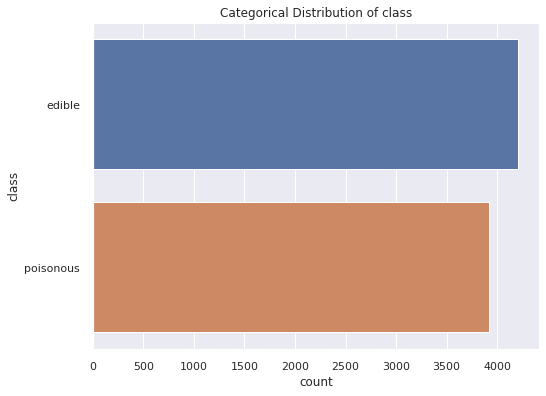

In [8]:
fig, counts = show_cat_dist(mush_df, "class")

In [9]:
mush_df["class"].value_counts()

edible       4208
poisonous    3916
Name: class, dtype: int64

In [10]:
4208 - 3916

292

There is a relatively even class balance between poisonous and edible mushrooms, with there being 292 more edible mushrooms in the entire dataset as compared to poisonous mushrooms. 

#### General Features

white        2388
brown        1968
black        1872
chocolate    1632
green          72
orange         48
purple         48
yellow         48
buff           48
Name: spore-print-color, dtype: int64

f    4748
t    3376
Name: bruises?, dtype: int64

none        3528
foul        2160
fishy        576
spicy        576
almond       400
anise        400
pungent      256
creosote     192
musty         36
Name: odor, dtype: int64

several      4040
solitary     1712
scattered    1248
numerous      400
abudant       384
clustered     340
Name: population, dtype: int64

woods      3148
grasses    2148
paths      1144
leaves      832
urban       368
meadows     292
waste       192
Name: habitat, dtype: int64

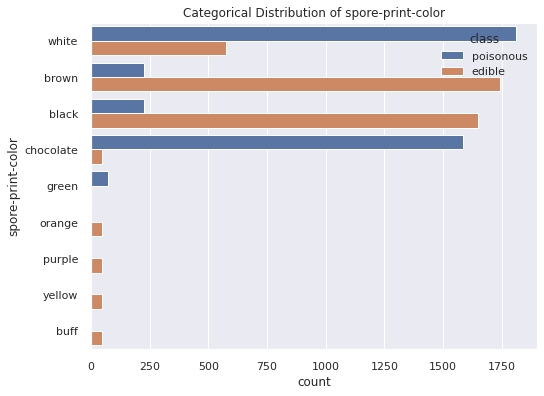

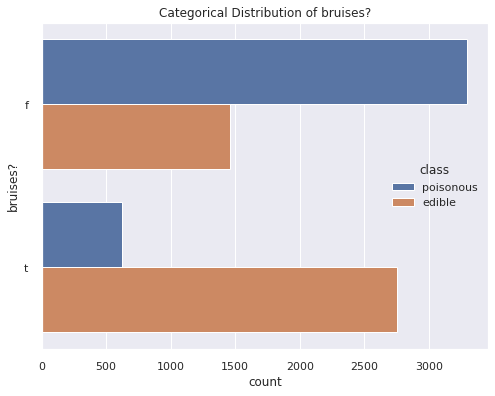

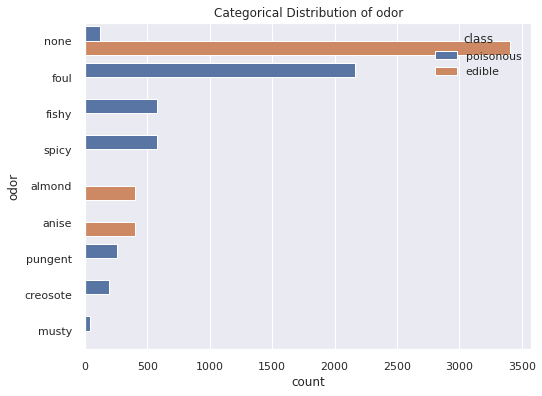

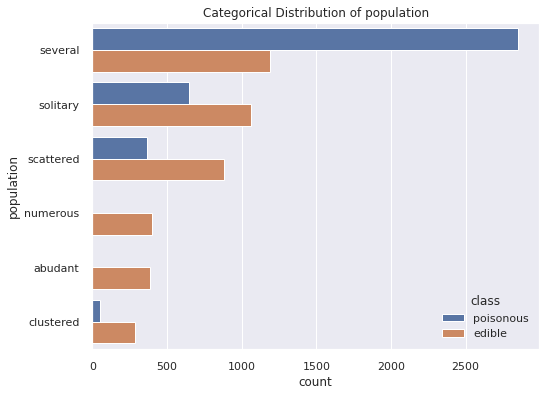

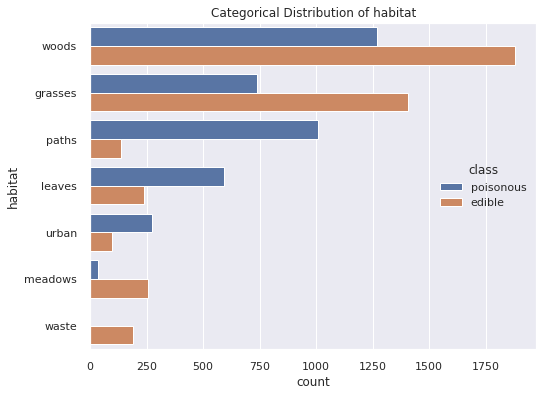

In [11]:
general_features = ['spore-print-color', 'bruises?', 'odor', 'population', 'habitat']
for feature in general_features:
    fig, counts = show_cat_dist(mush_df, feature, "class")
    display(counts)
    fig.show()

#### Mushroom Cap Features

convex     3656
flat       3152
knobbed     828
bell        452
sunken       32
conical       4
Name: cap-shape, dtype: int64
scaly      3244
smooth     2556
fibrous    2320
grooves       4
Name: cap-surface, dtype: int64
brown       2284
gray        1840
red         1500
yellow      1072
white       1040
buff         168
pink         144
cinnamon      44
purple        16
green         16
Name: cap-color, dtype: int64


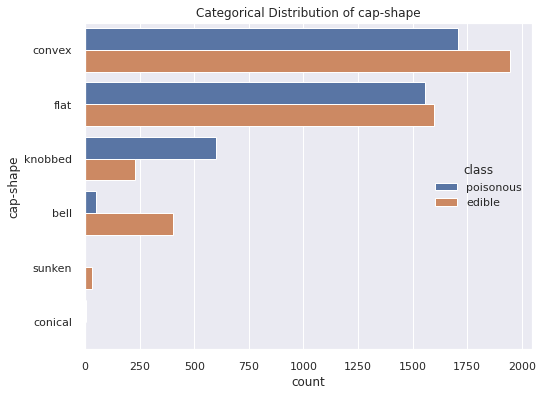

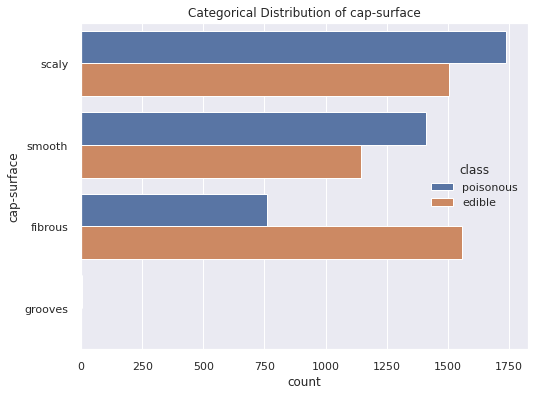

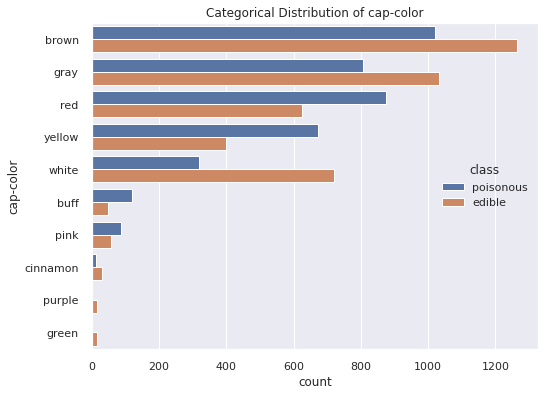

In [12]:
cap_features = ['cap-shape', 'cap-surface', 'cap-color']
for feature in cap_features:
    fig, counts = show_cat_dist(mush_df, feature, "class")
    print(counts)
    fig.show()

#### Gill Features

free        7914
attached     210
Name: gill-attachment, dtype: int64
close      6812
crowded    1312
Name: gill-spacing, dtype: int64
broad     5612
narrow    2512
Name: gill-size, dtype: int64
buff         1728
pink         1492
white        1202
brown        1048
gray          752
chocolate     732
purple        492
black         408
red            96
yellow         86
orange         64
green          24
Name: gill-color, dtype: int64


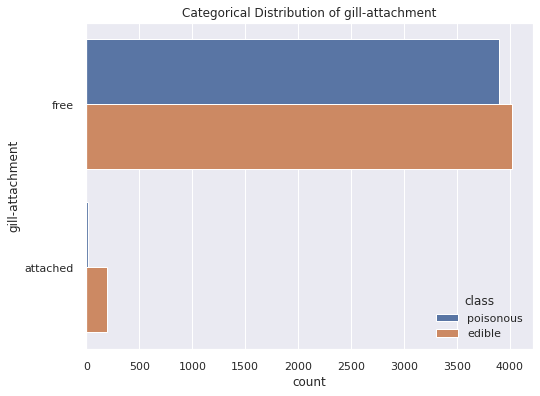

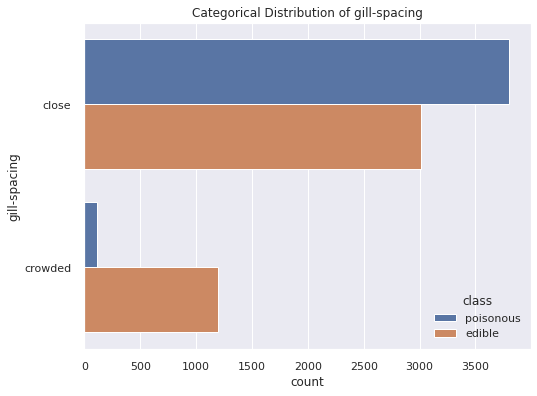

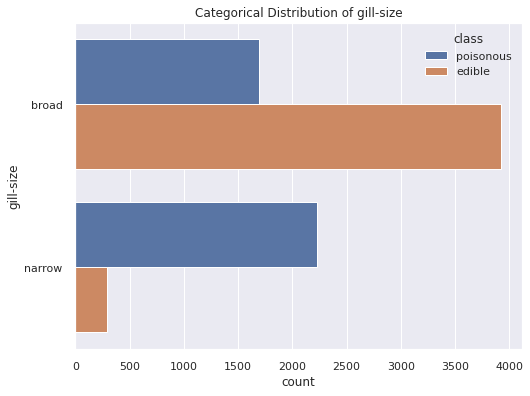

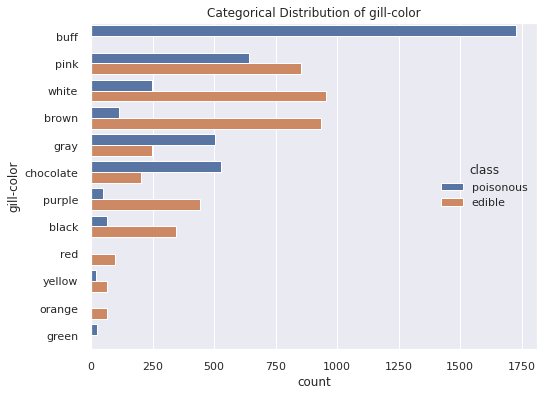

In [13]:
gill_features = ['gill-attachment', 'gill-spacing', 'gill-size', 'gill-color']
for feature in gill_features:
    fig, counts = show_cat_dist(mush_df, feature, "class")
    print(counts)
    fig.show()

In [14]:
mush_df.columns

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises?', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')

#### Stalk Features

tapering     4608
enlarging    3516
Name: stalk-shape, dtype: int64
bulbous    3776
equal      1120
club        556
rooted      192
Name: stalk-root, dtype: int64
smooth     5176
k          2372
fibrous     552
scaly        24
Name: stalk-surface-above-ring, dtype: int64
smooth     4936
k          2304
fibrous     600
scaly       284
Name: stalk-surface-below-ring, dtype: int64
white       4464
pink        1872
gray         576
brown        448
buff         432
orange       192
red           96
cinnamon      36
yellow         8
Name: stalk-color-above-ring, dtype: int64
white       4384
pink        1872
gray         576
brown        512
buff         432
orange       192
red           96
cinnamon      36
yellow        24
Name: stalk-color-below-ring, dtype: int64


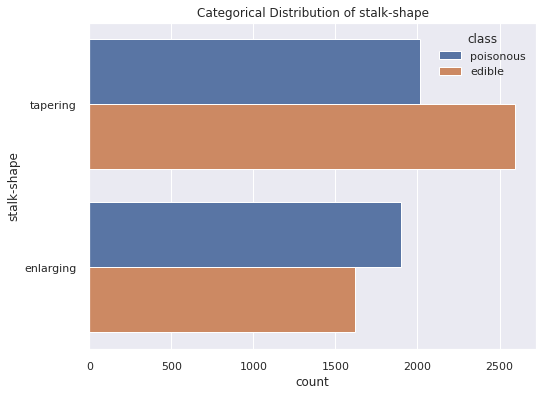

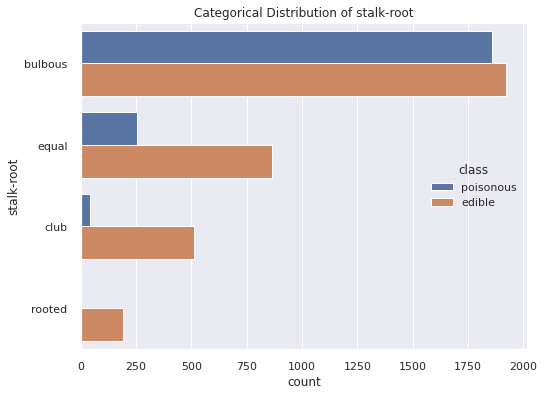

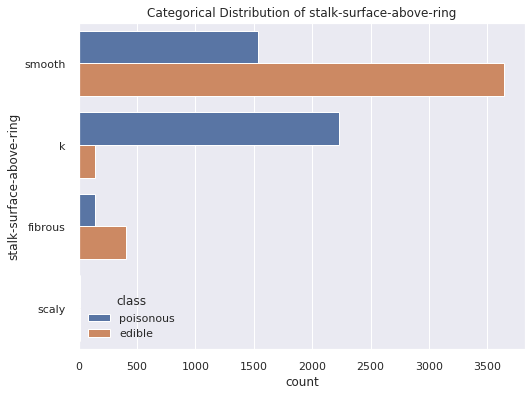

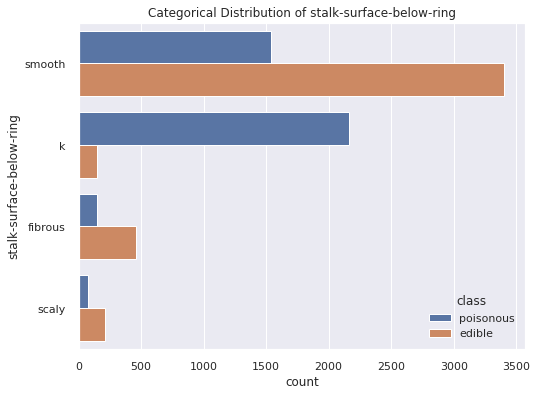

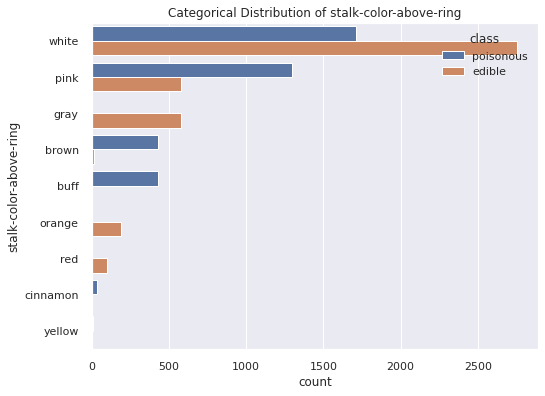

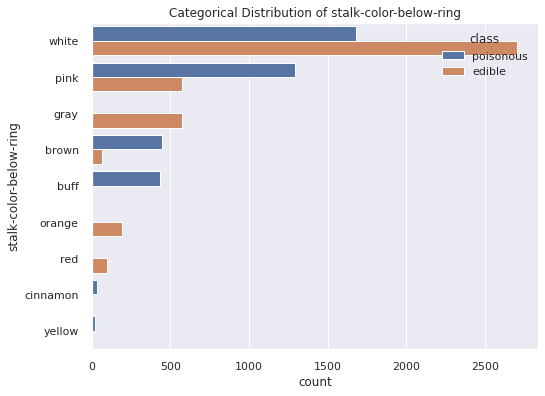

In [15]:
stalk_features = ['stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring']
for feature in stalk_features:
    fig, counts = show_cat_dist(mush_df, feature, "class")
    print(counts)
    fig.show()

#### Veil Features

partial    8124
Name: veil-type, dtype: int64
white     7924
orange      96
brown       96
yellow       8
Name: veil-color, dtype: int64


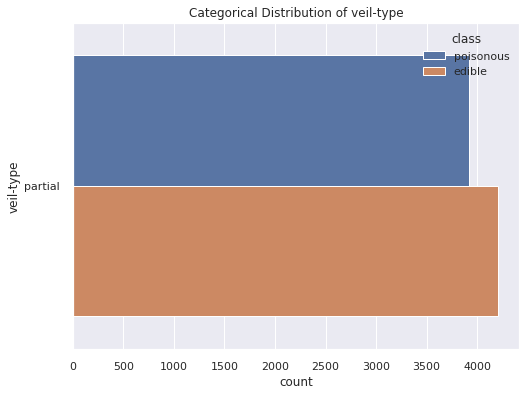

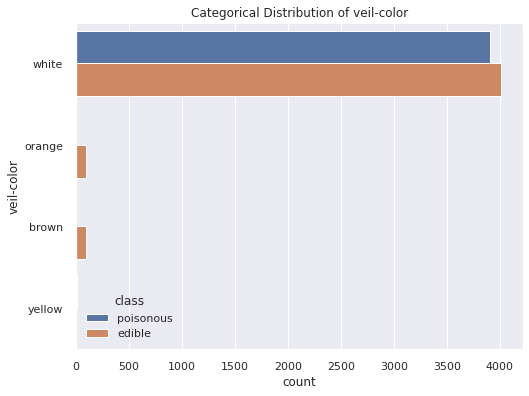

In [16]:
veil_features = ['veil-type', 'veil-color']
for feature in veil_features:
    fig, counts = show_cat_dist(mush_df, feature, "class")
    print(counts)
    fig.show()

#### Ring Features

one     7488
two      600
none      36
Name: ring-number, dtype: int64
pendant       3968
evanescent    2776
large         1296
flaring         48
none            36
Name: ring-type, dtype: int64


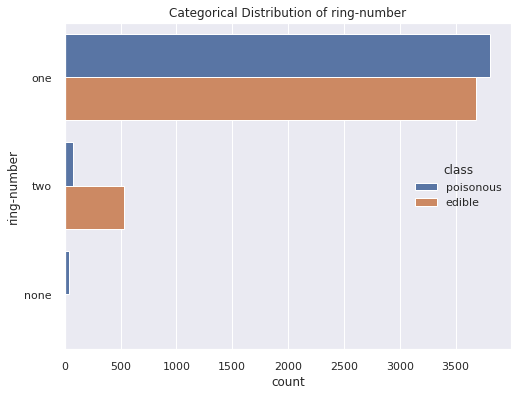

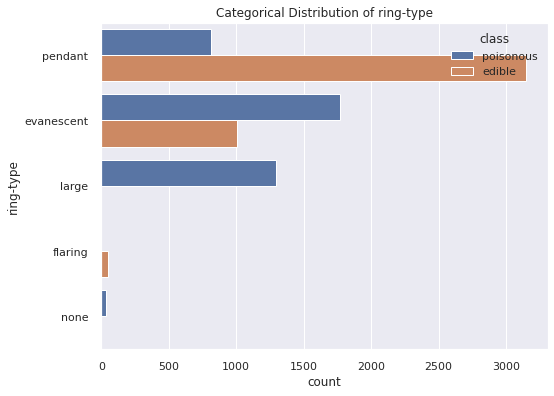

In [17]:
ring_features = ['ring-number',
       'ring-type']
for feature in ring_features:
    fig, counts = show_cat_dist(mush_df, feature, "class")
    print(counts)
    fig.show()


#### Summary of Insights From Checking the Distribution of Categorical Variables

### Checking for Low Variance Features

TypeError: Must pass either `items`, `like`, or `regex`

## Data Preprocessing

### Separate Features and Labels

In [18]:
X, y = mush_df.drop('class', axis = 1), mush_df["class"]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [19]:
y

array([1, 0, 0, ..., 0, 1, 0])

### Splitting Data into Training and Test Set

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 42)

### Data Preprocessing Pipeline: One-Hot Encoding

In [21]:
data_preprocess_steps = [
    ('Imputer', SimpleImputer(strategy='most_frequent')), # impute missing values with most frequent value
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore')) # one hot encode categorical data. We don't drop for other catergorical features as we want to make the features more interpretible (at cost to having extra dimensions in the data)
]
data_preprocessing = Pipeline(data_preprocess_steps)

## Modelling: Initial Baseline Model

In [67]:
from sklearn.dummy import DummyClassifier
clf = Pipeline(data_preprocess_steps + [
    ('Baseline Model', DummyClassifier(strategy="most_frequent"))
])

## Model Evaluation
To standardize the way the model is evaluated, we will create a function to automatically evaluate the model. 

It will:
- Get the score of the model on the cross-validation set.
- Get the score of the model on the hold-out set.
- Generate the learning curve of the candidate model.
- Generate a confusion matrix
- Plot ROC Curve
- Return the trained model (trained on the entire training set), if specified

In [63]:
def evalCandidateModel(model, X_train, X_test, y_train, y_test, scoring = 'accuracy', cv = 5, return_learning_curve = True):
    scores = cross_validate(model, X_train, y_train, scoring=scoring, return_estimator=True, return_train_score=True, cv=cv)
    best_estimator = scores["estimator"][np.argmax(scores["test_score"])]
    del scores["estimator"]
    scores = pd.DataFrame(scores)
      # If a hold out set is provided
    if X_test is not None and y_test is not None:
        scorer = get_scorer(scoring) # Then also score it, based off the scoring scheme provided
        scores["hold_out_score"] = scorer(best_estimator, X_test, y_test)
    # If user wants to create a learning_curve
        y_pred = best_estimator.predict(X_test)
        report = classification_report(y_test, y_pred)
        matrix = confusion_matrix(y_test, y_pred)
    if return_learning_curve:
        fig = learning_curve(model, X_train, y_train, scoring = scoring, n_jobs=-1, random_state = 42, cv =cv, show = False)
    else:
        fig = None # Else, return nothing
    return scores.describe().iloc[1:3, 2:].round(5), report, matrix ,fig,best_estimator


In [60]:
def evalHistory(new_score, model_name, history = None):
    if history is None:
        history = pd.DataFrame()
    new_score =new_score.iloc[0, :]
    new_score.rename(index=model_name, inplace=True)
    history = history.append(new_score)
    return history

/home/tiencheng/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,test_score,train_score,hold_out_score
mean,0.51777,0.51777,0.51877
std,0.00018,0.00004,0.00000


              precision    recall  f1-score   support

           0       0.52      1.00      0.68       843
           1       0.00      0.00      0.00       782

    accuracy                           0.52      1625
   macro avg       0.26      0.50      0.34      1625
weighted avg       0.27      0.52      0.35      1625

[[843   0]
 [782   0]]


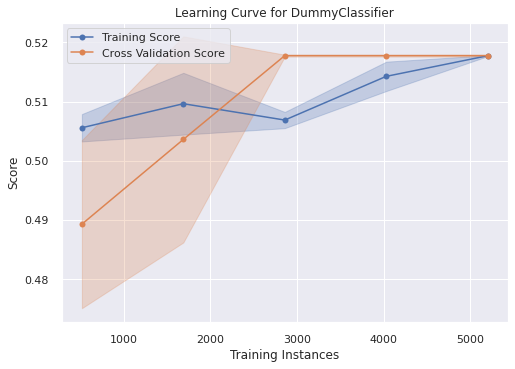

In [68]:
scores, report, matrix, fig, baseline = evalCandidateModel(clf, X_train, X_test, y_train, y_test)
history = evalHistory(scores, "Baseline (Mode Predictor)")
display(scores)
print(report)
print(matrix)



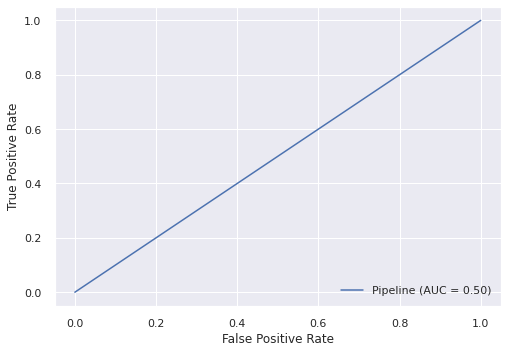

In [69]:
plot_roc_curve(baseline, X_test, y_test)

In [70]:
history

,hold_out_score,test_score,train_score
Baseline (Mode Predictor),0.51877,0.51777,0.51777


The baseline classifier 

## Modelling: Decision Tree

In [71]:
from sklearn.tree import DecisionTreeClassifier
clf = Pipeline(data_preprocess_steps + [
    ('Baseline Model', DecisionTreeClassifier(max_depth=2))
])

,test_score,train_score,hold_out_score
mean,0.94999,0.95211,0.944
std,0.00382,0.00503,0.000


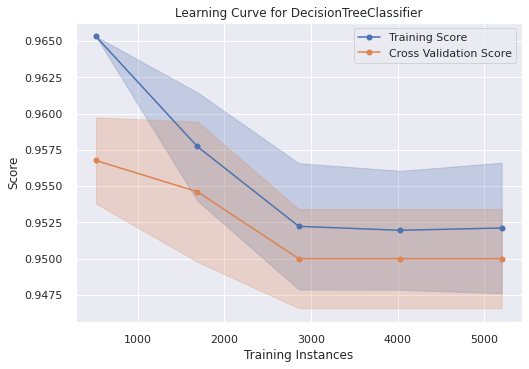

In [75]:
scores,report, matrix, fig, dt = evalCandidateModel(clf, X_train, X_test, y_train, y_test)
history = evalHistory(scores, "Decision Tree", history)
display(scores)

In [76]:
history

,hold_out_score,test_score,train_score
Baseline (Mode Predictor),0.51877,0.51777,0.51777
Decision Tree,0.94400,0.94999,0.95211


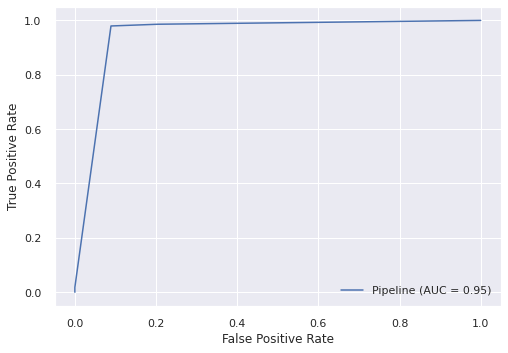

In [66]:
plot_roc_curve(dt, X_test, y_test)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


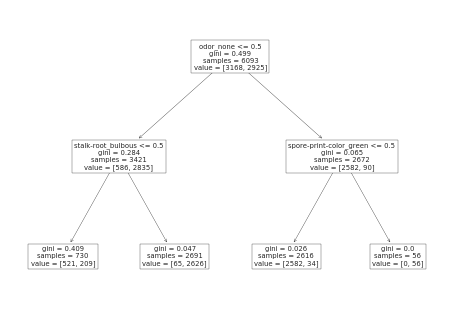

In [33]:
tree = clf[-1]
feature_names = clf[-2].get_feature_names(X.columns)
from sklearn.tree import plot_tree 
plt_tree = plot_tree(dt, feature_names=feature_names)
